In [21]:
# imports and loading
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
from pymodulon.io import *
from matplotlib_venn import venn3
from pymodulon.enrichment import *
import os
from statsmodels.stats.multitest import fdrcorrection

base_dir = '/home/chris/zuniga/iModulonMiner'
TRN_df = pd.read_csv(os.path.join(base_dir, 'data', 'external', 'TRN.csv'), index_col = 0)
ica_data = load_json_model(os.path.join(base_dir, 'data', 'interim', 'zmo_raw.json.gz'))


/home/chris/miniforge3/envs/iM_miner/lib/python3.10/site-packages/pymodulon/util.py:31: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table = pd.read_json(table)
/home/chris/miniforge3/envs/iM_miner/lib/python3.10/site-packages/pymodulon/util.py:31: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table = pd.read_json(table)
/home/chris/miniforge3/envs/iM_miner/lib/python3.10/site-packages/pymodulon/util.py:31: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table = pd.read_json(table)
/home/chris/miniforge3/envs/iM_miner/lib/python3.10/site-packages/pymodulon/util.py:31: FutureWarning: Passing literal json to 'read_json' 

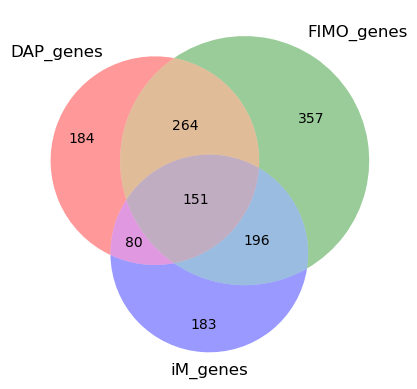

In [11]:
all_genes = set(ica_data.gene_table.index)
DAP_genes = set(TRN_df.gene_id)
df = ica_data.gene_table.fillna(0)
iM_genes = set(df[df['iMs'] != 0].index)
df = ica_data.gene_table
FIMO_genes = set(df[[len(val) > 2 for val in ica_data.gene_table['FIMO_regulators']]].index)


venn3([DAP_genes, FIMO_genes, iM_genes], ('DAP_genes', 'FIMO_genes', 'iM_genes'))
plt.savefig(os.path.join(base_dir, 'figures', 'venn3_overlap.pdf'), transparent = True)
plt.show()

In [12]:
shared = list(DAP_genes.intersection(FIMO_genes).intersection(iM_genes))

In [13]:
a = ica_data.gene_table.loc[shared]['COG'].value_counts() / len(shared)
a1 = ica_data.gene_table.loc[list(iM_genes)]['COG'].value_counts() / len(list(iM_genes))

In [14]:
b = ica_data.gene_table['COG'].value_counts() / len(ica_data.gene_table.index)

In [15]:
(a1 - b).sort_values()

COG
Replication, recombination and repair                               -0.024979
Nucleotide transport and metabolism                                 -0.015181
Lipid transport and metabolism                                      -0.011379
Amino acid transport and metabolism                                 -0.010641
Cell cycle control, cell division, chromosome partitioning          -0.009232
Post-translational modification, protein turnover, and chaperones   -0.008624
Coenzyme transport and metabolism                                   -0.008602
Function unknown                                                    -0.007629
Intracellular trafficking, secretion, and vesicular transport       -0.005959
Secondary metabolites biosynthesis, transport, and catabolism       -0.004886
Transcription                                                       -0.003107
Defense mechanisms                                                  -0.001036
Signal transduction mechanisms                              

In [31]:
df = ica_data.gene_table
og_use = iM_genes
results = []
for COG in a.index:
    target = df[df['COG'] == COG].index.to_list()
    gene_set = list(og_use)
    res = compute_enrichment(gene_set, target, df.index)
    results.append(res)
res_df = pd.DataFrame(results)
res_df['COG'] = a.index
_, qvalues = fdrcorrection(res_df['pvalue'])
res_df['qvalue'] = qvalues
res_df = res_df[['COG', 'pvalue', 'qvalue', 'precision', 'recall', 'f1score', 'TP', 'target_set_size', 'gene_set_size']]

In [32]:
res_df.sort_values(by = 'qvalue').head()

COG    pvalue    qvalue  \
2            Inorganic ion transport and metabolism  0.000018  0.000333   
5                  Energy production and conversion  0.000756  0.006808   
1                                 No COG annotation  0.002206  0.013237   
13                                    Cell motility  0.092358  0.332490   
12  Translation, ribosomal structure and biogenesis  0.085675  0.332490   

    precision    recall   f1score    TP  target_set_size  gene_set_size  
2    0.068852  0.567568  0.122807  42.0             74.0          610.0  
5    0.080328  0.485149  0.137834  49.0            101.0          610.0  
1    0.137705  0.426396  0.208178  84.0            197.0          610.0  
13   0.032787  0.434783  0.060976  20.0             46.0          610.0  
12   0.096721  0.385621  0.154653  59.0            153.0          610.0

In [25]:
qvalues

array([9.99946230e-01, 1.32367562e-02, 3.32677392e-04, 9.99946230e-01,
       9.99946230e-01, 6.80769212e-03, 9.99946230e-01, 9.99946230e-01,
       9.99946230e-01, 9.99946230e-01, 9.99946230e-01, 5.54788718e-01,
       3.32489515e-01, 3.32489515e-01, 9.99946230e-01, 9.99946230e-01,
       9.99946230e-01, 9.99946230e-01])